In [ ]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
nerf_code_dir = os.path.abspath(os.path.join(current_dir, '../../../code/NeRF/nerf-pytorch-master'))
if nerf_code_dir not in sys.path:
    sys.path.append(nerf_code_dir)

print(f"✅ Added {nerf_code_dir} to sys.path")
import matplotlib.pyplot as plt
import numpy as np
import imageio
import json
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

from run_nerf_helpers import *
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from load_llff import load_llff_data
from load_deepvoxels import load_dv_data
from load_blender import load_blender_data
from load_LINEMOD import load_LINEMOD_data
import configargparse
from run_nerf import batchify, run_network, batchify_rays, render, render_path, create_nerf, raw2outputs, render_rays, config_parser

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
DEBUG = False
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_default_tensor_type('torch.cuda.FloatTensor')
parser = config_parser()
# args = parser.parse_args()


# parser = config_parser()
args = parser.parse_args([
    '--config', '/home/xqgao/2025/MIT/code/NeRF/nerf-pytorch-master/configs/lego.yaml'
])

# Load data
K = None
if args.dataset_type == 'llff':
    images, poses, bds, render_poses, i_test = load_llff_data(args.datadir, args.factor,
                                                                recenter=True, bd_factor=.75,
                                                                spherify=args.spherify)
    hwf = poses[0,:3,-1]
    poses = poses[:,:3,:4]
    print('Loaded llff', images.shape, render_poses.shape, hwf, args.datadir)
    if not isinstance(i_test, list):
        i_test = [i_test]

    if args.llffhold > 0:
        print('Auto LLFF holdout,', args.llffhold)
        i_test = np.arange(images.shape[0])[::args.llffhold]

    i_val = i_test
    i_train = np.array([i for i in np.arange(int(images.shape[0])) if
                    (i not in i_test and i not in i_val)])

    print('DEFINING BOUNDS')
    if args.no_ndc:
        near = np.ndarray.min(bds) * .9
        far = np.ndarray.max(bds) * 1.
        
    else:
        near = 0.
        far = 1.
    print('NEAR FAR', near, far)

elif args.dataset_type == 'blender':
    images, poses, render_poses, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)
    print('Loaded blender', images.shape, render_poses.shape, hwf, args.datadir)
    i_train, i_val, i_test = i_split

    near = 2.
    far = 6.

    if args.white_bkgd:
        images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
    else:
        images = images[...,:3]

elif args.dataset_type == 'LINEMOD':
    images, poses, render_poses, hwf, K, i_split, near, far = load_LINEMOD_data(args.datadir, args.half_res, args.testskip)
    print(f'Loaded LINEMOD, images shape: {images.shape}, hwf: {hwf}, K: {K}')
    print(f'[CHECK HERE] near: {near}, far: {far}.')
    i_train, i_val, i_test = i_split

    if args.white_bkgd:
        images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
    else:
        images = images[...,:3]

elif args.dataset_type == 'deepvoxels':

    images, poses, render_poses, hwf, i_split = load_dv_data(scene=args.shape,
                                                                basedir=args.datadir,
                                                                testskip=args.testskip)

    print('Loaded deepvoxels', images.shape, render_poses.shape, hwf, args.datadir)
    i_train, i_val, i_test = i_split

    hemi_R = np.mean(np.linalg.norm(poses[:,:3,-1], axis=-1))
    near = hemi_R-1.
    far = hemi_R+1.

else:
    print('Unknown dataset type', args.dataset_type, 'exiting')
    return

# Cast intrinsics to right types
H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]

if K is None:
    K = np.array([
        [focal, 0, 0.5*W],
        [0, focal, 0.5*H],
        [0, 0, 1]
    ])

if args.render_test:
    render_poses = np.array(poses[i_test])

# Create log dir and copy the config file
basedir = args.basedir
expname = args.expname
os.makedirs(os.path.join(basedir, expname), exist_ok=True)
f = os.path.join(basedir, expname, 'args.txt')
with open(f, 'w') as file:
    for arg in sorted(vars(args)):
        attr = getattr(args, arg)
        file.write('{} = {}\n'.format(arg, attr))
if args.config is not None:
    f = os.path.join(basedir, expname, 'config.txt')
    with open(f, 'w') as file:
        file.write(open(args.config, 'r').read())

# Create nerf model
render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer = create_nerf(args)
global_step = start

bds_dict = {
    'near' : near,
    'far' : far,
}
render_kwargs_train.update(bds_dict)
render_kwargs_test.update(bds_dict)

# Move testing data to GPU
render_poses = torch.Tensor(render_poses).to(device)

# Short circuit if only rendering out from trained model

Loaded blender (138, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, 555.5555155968841] /home/xqgao/2025/MIT/Datasets/NeRF/nerf_synthetic/lego


/home/xqgao/2025/MIT/code/NeRF/nerf-pytorch-master/run_nerf.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path)


Found ckpts ['/home/xqgao/2025/MIT/code/NeRF/nerf-pytorch-master/pre_trained_models/lego_test/200000.tar']
Reloading from /home/xqgao/2025/MIT/code/NeRF/nerf-pytorch-master/pre_trained_models/lego_test/200000.tar
Not ndc!
RENDER ONLY
test poses shape torch.Size([40, 4, 4])


  0%|          | 0/40 [00:00<?, ?it/s]

0 0.003720521926879883


/home/xqgao/anaconda3/envs/inr/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  2%|▎         | 1/40 [00:04<02:59,  4.60s/it]

torch.Size([400, 400, 3]) torch.Size([400, 400])
1 4.598506450653076


  5%|▌         | 2/40 [00:09<02:54,  4.60s/it]

2 4.592915058135986


  8%|▊         | 3/40 [00:13<02:50,  4.60s/it]

3 4.597219228744507


 10%|█         | 4/40 [00:18<02:45,  4.60s/it]

4 4.608144760131836


 12%|█▎        | 5/40 [00:23<02:41,  4.61s/it]

5 4.616270542144775


 15%|█▌        | 6/40 [00:27<02:36,  4.61s/it]

6 4.621382713317871


 18%|█▊        | 7/40 [00:32<02:32,  4.62s/it]

7 4.627427816390991


 20%|██        | 8/40 [00:36<02:27,  4.62s/it]

8 4.628061056137085


 22%|██▎       | 9/40 [00:41<02:23,  4.62s/it]

9 4.631645679473877


 25%|██▌       | 10/40 [00:46<02:18,  4.63s/it]

10 4.637068033218384


 28%|██▊       | 11/40 [00:50<02:14,  4.63s/it]

11 4.635892868041992


 30%|███       | 12/40 [00:55<02:09,  4.63s/it]

12 4.641714096069336


 32%|███▎      | 13/40 [01:00<02:05,  4.64s/it]

13 4.64192795753479


 35%|███▌      | 14/40 [01:04<02:00,  4.64s/it]

14 4.65056586265564


 38%|███▊      | 15/40 [01:09<01:56,  4.65s/it]

15 4.6586198806762695


 40%|████      | 16/40 [01:14<01:51,  4.65s/it]

16 4.655009508132935


 42%|████▎     | 17/40 [01:18<01:46,  4.65s/it]

17 4.658567905426025


 45%|████▌     | 18/40 [01:23<01:42,  4.65s/it]

18 4.66052770614624


 48%|████▊     | 19/40 [01:28<01:37,  4.66s/it]

19 4.661770343780518


 50%|█████     | 20/40 [01:32<01:33,  4.66s/it]

20 4.6580963134765625


 52%|█████▎    | 21/40 [01:37<01:28,  4.66s/it]

21 4.662529468536377


 55%|█████▌    | 22/40 [01:42<01:23,  4.66s/it]

22 4.662933349609375


 57%|█████▊    | 23/40 [01:46<01:19,  4.66s/it]

23 4.6700005531311035


 60%|██████    | 24/40 [01:51<01:14,  4.67s/it]

24 4.672757863998413


 62%|██████▎   | 25/40 [01:56<01:10,  4.67s/it]

25 4.671373605728149


 65%|██████▌   | 26/40 [02:00<01:05,  4.67s/it]

26 4.674701690673828


 68%|██████▊   | 27/40 [02:05<01:00,  4.67s/it]

27 4.67028284072876


 70%|███████   | 28/40 [02:10<00:56,  4.67s/it]

28 4.675526142120361


 72%|███████▎  | 29/40 [02:14<00:51,  4.67s/it]

29 4.679644823074341


 75%|███████▌  | 30/40 [02:19<00:46,  4.68s/it]

30 4.680464029312134


 78%|███████▊  | 31/40 [02:24<00:42,  4.68s/it]

31 4.681898832321167


 80%|████████  | 32/40 [02:28<00:37,  4.68s/it]

32 4.676936149597168


 82%|████████▎ | 33/40 [02:33<00:32,  4.68s/it]

33 4.678430557250977


 85%|████████▌ | 34/40 [02:38<00:28,  4.68s/it]

34 4.6854894161224365


 88%|████████▊ | 35/40 [02:42<00:23,  4.68s/it]

35 4.684006929397583


 90%|█████████ | 36/40 [02:47<00:18,  4.68s/it]

36 4.685177326202393


 92%|█████████▎| 37/40 [02:52<00:14,  4.68s/it]

37 4.685378551483154


 95%|█████████▌| 38/40 [02:56<00:09,  4.69s/it]

38 4.690970182418823


 98%|█████████▊| 39/40 [03:01<00:04,  4.68s/it]

39 4.682691812515259


100%|██████████| 40/40 [03:06<00:00,  4.66s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done rendering /home/xqgao/2025/MIT/code/NeRF/nerf-pytorch-master/logs/blender_paper_lego/renderonly_path_200000


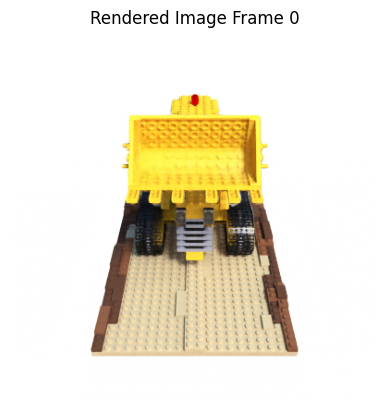

In [ ]:
print('RENDER ONLY')
with torch.no_grad():
    if args.render_test:
        # render_test switches to test poses
        images = images[i_test]
    else:
        # Default is smoother render_poses path
        images = None

    testsavedir = os.path.join(basedir, expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', start))
    os.makedirs(testsavedir, exist_ok=True)
    print('test poses shape', render_poses.shape)

    rgbs, _ = render_path(render_poses, hwf, K, args.chunk, render_kwargs_test, gt_imgs=images, savedir=testsavedir, render_factor=args.render_factor)
    print('Done rendering', testsavedir)

    img = rgbs[0]  # shape: (H, W, 3), dtype: float32, range: [0, 1]
    plt.imshow(img)
    plt.title("Rendered Image Frame 0")
    plt.axis("off")
    plt.show()

    imageio.mimwrite(os.path.join(testsavedir, 'video.mp4'), to8b(rgbs), fps=30, quality=8)